In [1]:
from math import log
import operator
import pickle
import treePlotter

# create data to test fish
def createDataSet():
    labels = ['no surfacing', 'flippers']
    dataSet = [[1, 1, 'yes'],
               [1, 1, 'yes'],
               [1, 0, 'no'],
               [0, 1, 'no'],
               [0, 1, 'no']]
    return dataSet, labels

# calculate shannon entropy
def calculateEntropy(dataSet):
    numEntries = len(dataSet)
    labelCounts = {}
    for vector in dataSet:
        # use last column label to calculate
        curr = vector[-1]
        if curr not in labelCounts.keys():
            labelCounts[curr] = 0
        labelCounts[curr] += 1
    # print labelCounts
    
    entropy = 0.0
    for key in labelCounts:
        prob = float(labelCounts[key]) / numEntries
        entropy -= prob * log(prob, 2)
        # print "key: %s, probability: %f, log func: %f" \
        #    %(key, prob, log(prob, 2))
    return entropy

dataSet, labels = createDataSet()
calculateEntropy(dataSet)

0.9709505944546686

In [2]:
# split data set by axis & value
def splitDataSet(dataSet, axis, value):
    # create new data set to avoid change on original one
    reducedDataSet = []
    for vector in dataSet:
        if vector[axis] == value:
            reducedVector = vector[:axis]
            reducedVector.extend(vector[axis + 1:])
            reducedDataSet.append(reducedVector)
    return reducedDataSet

reduced1 = splitDataSet(dataSet, 0, 1)
print reduced1
reduced2 = splitDataSet(dataSet, 0, 0)
print reduced2

[[1, 'yes'], [1, 'yes'], [0, 'no']]
[[1, 'no'], [1, 'no']]


In [3]:
# choose the best split feature
def chooseBestSplitFeature(dataSet):
    # last column is the class label
    numFeatures = len(dataSet[0]) - 1
    baseEntropy = calculateEntropy(dataSet)
    print "original entropy: %f" %(baseEntropy)
    bestInfoGain = 0.0
    bestFeature = -1
    
    # iterate features and calculate entropy
    for i in range(numFeatures):
        # convert column i data to feature array
        featureList = [example[i] for example in dataSet]
        # print featureList
        # retrieve unique values of each feature
        uniqueVals = set(featureList)
        newEntropy = 0.0
        for value in uniqueVals:
            subDataSet = splitDataSet(dataSet, i, value)
            prob = len(subDataSet) / float(len(dataSet))
            newEntropy += prob * calculateEntropy(subDataSet)
        reducedEntropy = baseEntropy - newEntropy
        print "curr index: %d, new entropy: %f, reduced entropy: %f" \
            %(i, newEntropy, reducedEntropy)
        
        if (reducedEntropy > bestInfoGain):
            bestInfoGain = reducedEntropy
            bestFeature = i
    
    return bestFeature

chooseBestSplitFeature(dataSet)

original entropy: 0.970951
curr index: 0, new entropy: 0.550978, reduced entropy: 0.419973
curr index: 1, new entropy: 0.800000, reduced entropy: 0.170951


0

In [4]:
# find the top class in the list
def majorityCount(classList):
    classCount = {}
    for vote in classList:
        if vote not in classCount.keys():
            classCount[vote] = 0
        classCount[vote] += 1
    sortedClassCount = sorted(classCount.iteritems(), 
        key = operator.itemgetter(1), reverse = True)
    return sortedClassCount[0][0]

# input data set and feature labels
def createTree(dataSet, featureLabels):
    classList = [example[-1] for example in dataSet]
    
    # stop and return if all classes are the same
    if classList.count(classList[0]) == len(classList):
        return classList[0]
    
    # check if all the features have been used up
    # return majority class in case not classified
    if len(dataSet[0]) == 1:
        return majorityCount(classList)
    
    # select best feature and label
    bestFeature = chooseBestSplitFeature(dataSet)
    bestFeatureLabel = featureLabels[bestFeature]
    print 'best feature is: %d - %s' % (bestFeature, bestFeatureLabel)
    myTree = {bestFeatureLabel: {}}
    
    del(featureLabels[bestFeature])
    featureValues = [example[bestFeature] for example in dataSet]
    uniqueValues = set(featureValues)
    for value in uniqueValues:
        subLabels = featureLabels[:]
        
        # iterate to construct sub-trees
        myTree[bestFeatureLabel][value] = \
            createTree(splitDataSet(dataSet, bestFeature, value), subLabels)
    
    return myTree

dataSet, labels = createDataSet()
myTree = createTree(dataSet, labels)
myTree

original entropy: 0.970951
curr index: 0, new entropy: 0.550978, reduced entropy: 0.419973
curr index: 1, new entropy: 0.800000, reduced entropy: 0.170951
best feature is: 0 - no surfacing
original entropy: 0.918296
curr index: 0, new entropy: 0.000000, reduced entropy: 0.918296
best feature is: 0 - flippers


{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

In [13]:
# classification using decision tree algorithm
# featureLabels and testVector are consistent
def classify(inputTree, featureLabels, testVector):
    currKey = inputTree.keys()[0]
    currDict = inputTree[currKey]
    
    # get correct feature index by current key
    featureIndex = featureLabels.index(currKey)
    for key in currDict.keys():
        if testVector[featureIndex] == key:
            if type(currDict[key]).__name__ == 'dict':
                classLabel = classify(currDict[key], featureLabels, testVector)
            else:
                classLabel = currDict[key]
    return classLabel

# store tree to local file
def storeTree(inputTree, filename):
    fw = open(filename, 'w')
    pickle.dump(inputTree, fw)
    fw.close()

# restore tree from local file
def grabTree(filename):
    fr = open(filename)
    return pickle.load(fr)

dataSet, labels = createDataSet()
myTree = treePlotter.retrieveTree(0)
classify(myTree, labels, [1, 0])
storeTree(myTree, 'tree.model')
grabTree('tree.model')

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

original entropy: 1.326088
curr index: 0, new entropy: 1.286691, reduced entropy: 0.039397
curr index: 1, new entropy: 1.286577, reduced entropy: 0.039511
curr index: 2, new entropy: 0.949082, reduced entropy: 0.377005
curr index: 3, new entropy: 0.777293, reduced entropy: 0.548795
best feature is: 3 - tearRate
original entropy: 1.554585
curr index: 0, new entropy: 1.333333, reduced entropy: 0.221252
curr index: 1, new entropy: 1.459148, reduced entropy: 0.095437
curr index: 2, new entropy: 0.784159, reduced entropy: 0.770426
best feature is: 2 - astigmatic
original entropy: 0.918296
curr index: 0, new entropy: 0.666667, reduced entropy: 0.251629
curr index: 1, new entropy: 0.459148, reduced entropy: 0.459148
best feature is: 1 - prescript
original entropy: 0.918296
curr index: 0, new entropy: 0.000000, reduced entropy: 0.918296
best feature is: 0 - age
original entropy: 0.650022
curr index: 0, new entropy: 0.333333, reduced entropy: 0.316689
curr index: 1, new entropy: 0.459148, reduc

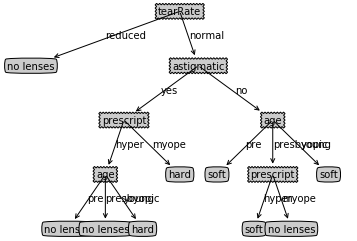

In [16]:
## lenses doctor query test
def checkLenses():
    fr = open('data/lenses.txt')
    lenses = [line.strip().split('\t') for line in fr.readlines()]
    lensesLabels = ['age', 'prescript', 'astigmatic', 'tearRate']
    lensesTree = createTree(lenses, lensesLabels)
    print lensesTree
    treePlotter.createPlot(lensesTree)

checkLenses()